# xarray module tutorial

In this tutorial, we will learn how to use Eradiate's xarray extensions. In addition to this introduction, it is recommended to refer to the [technical documentation](../../../rst/api_reference/generated/eradiate.util.xarray.rst). We assume here that you are familiar with xarray's [basics concepts](http://xarray.pydata.org/en/stable/quick-overview.html) and [terminology](http://xarray.pydata.org/en/stable/terminology.html).

It is strongly recommended to execute the Python code presented here in a Jupyter notebook.

<div class="alert alert-info">

This tutorial is available as a Jupyter notebook in the Eradiate codebase 
[`$ERADIATE_DIR/resources/data/notebooks/tutorials/xarray/xarray.ipynb`].

</div>

## Our approach to data handling

Eradiate makes extensive use of the xarray library to propose a neat data workflow. Thanks to xarray, we have access to a convenient and efficient data handling framework with built-in advanced data arithmetics, convenient data browsing and selection facilities, a plotting framework, metadata handling and many I/O formats.

Eradiate extends xarray with the recommended [accessor method](http://xarray.pydata.org/en/stable/internals.html#extending-xarray). Its [data array](../../../rst/api_reference/generated/eradiate.util.xarray.EradiateDataArrayAccessor.rst) and [dataset](../../../rst/api_reference/generated/eradiate.util.xarray.EradiateDatasetAccessor.rst) accessors are automatically created upon importing any Eradiate module or submodule and respectively accessed using the `DataArray.ert` and `Dataset.ert` members. These accessors wrap other facilities used for various purposes, _e.g._ data creation, slicing, metadata validation and normalisation, plotting, etc.

## Data array slicing and visualisation

In order to demonstrate these facilities, let's first start by creating some data. We'll run a simple 1D simulation with a Rayleigh atmosphere and an illumination zenith angle of 30°. We keep the default atmosphere and surface (Lambertian) and increase the number of samples per pixel to a high value:

In [1]:
from eradiate.solvers.onedim.app import OneDimSolverApp
app = OneDimSolverApp(config={
    "atmosphere": {
        "type": "heterogeneous",
        "profile": {"type": "us76_approx"},
        "width": 1e5,
        "width_units": "km"
    },
    "surface": {
        "type": "rpv"
    },
    "illumination": {
        "type": "directional",
        "zenith": 30.,
        "zenith_units": "deg"
    },
    "measure": [{
        "type": "toa_hsphere",
        "spp": int(1e4)
    }]
})
app.config["measure"][0]["spp"] = int(1e6)
app.run()

We can now access the only measure data we have requested:

In [2]:
sample_data = next(iter(app.results.values()))
sample_data

<xarray.Dataset>
Dimensions:     (saa: 1, sza: 1, vaa: 36, vza: 9, wavelength: 1)
Coordinates:
  * sza         (sza) float64 30.0
  * saa         (saa) float64 0.0
  * vza         (vza) float64 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0
  * vaa         (vaa) float64 0.0 10.0 20.0 30.0 ... 320.0 330.0 340.0 350.0
  * wavelength  (wavelength) float64 550.0
Data variables:
    lo          (sza, saa, vza, vaa, wavelength) float64 2.593e+05 ... 2.679e+05
    irradiance  (sza, saa, wavelength) float64 8.66e+05
    brdf        (sza, saa, vza, vaa, wavelength) float64 0.2994 ... 0.3094
    brf         (sza, saa, vza, vaa, wavelength) float64 0.9406 ... 0.9719
Attributes:
    convention:  CF-1.8
    title:       Top-of-atmosphere simulation results
    history:     2020-12-02 10:02:37 - data creation - eradiate.solvers.onedi...
    source:      eradiate, version 0.0.1
    references:

This dataset has 5 coordinate variables and 4 data variables. As we can see from the visualisation, we can see that the dataset, data variables and coordinate variables are documented. We can very easily visualise the top-of-atmosphere BRF over the hemisphere using the data array accessor:

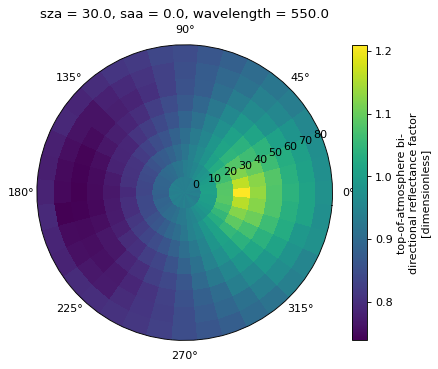

In [3]:
import matplotlib.pyplot as plt
import eradiate.util.plot as ertplt

brf = sample_data.brf

brf.squeeze().ert.plot_pcolormesh_polar() # note that we must first eliminate the excess dimensions with squeeze()
ertplt.remove_xylabels() # remove X and Y axis labels
plt.show()

Some people will argue that this view is not very comprehensive and that they'd prefer to use a principal plane view for their analysis. We can easily extract a principal plane view from our TOA BRF hemispherical data and plot it using the regular xarray plotting tools:

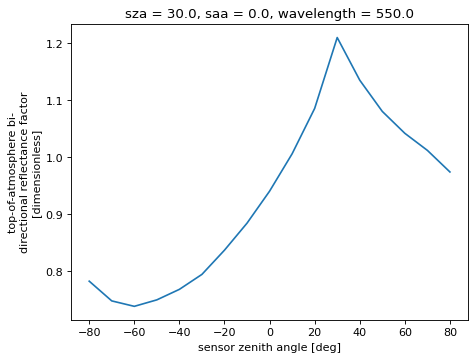

In [4]:
brf.ert.extract_pplane().plot()
plt.show()

But we can also extract a plane view for any azimuth value:

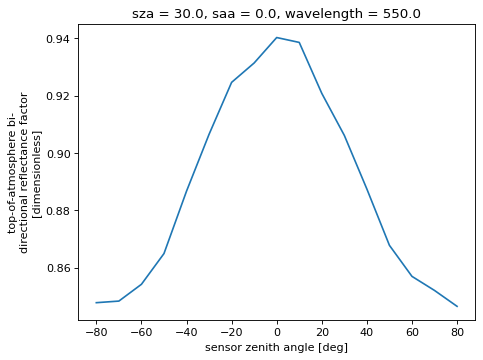

In [5]:
# here we must specify the azimuth and zenith coordinates used to extract this plane view
brf.ert.extract_plane(phi=90., theta_dim="vza", phi_dim="vaa").plot()
plt.show()

## Advanced: Faceting test

The following example shows how the `plot_pcolormesh_polar()` method allows for [faceting](http://xarray.pydata.org/en/stable/plotting.html#faceting) just like xarray's `pcolormesh()` method:

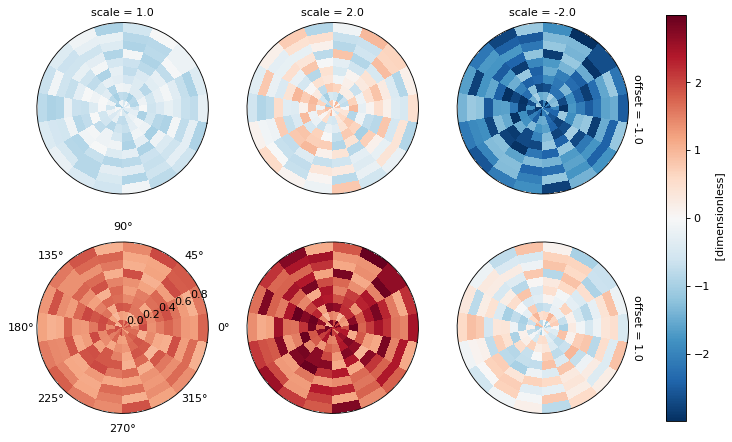

In [6]:
# Faceting test
import numpy as np
import xarray as xr
import pint

ureg = pint.UnitRegistry()

res_r = 0.1
rs = np.arange(0, 1, res_r)
res_theta = 20
thetas = np.arange(0, 360, res_theta)

scales = np.array([1, 2, -2], dtype=float)
offsets = np.array([0, -1, 1], dtype=float)

data_base = np.random.random((len(rs), len(thetas)))
data = np.zeros(data_base.shape + scales.shape + offsets.shape)

for i_scale, scale in enumerate(scales):
    for i_offset, offset in enumerate(offsets):
        data[:, :, i_scale, i_offset] = data_base * scale + offset

my_da = xr.DataArray(
    data,
    coords=(rs, thetas, scales, offsets),
    dims=("r", "theta", "scale", "offset"),
)
my_da.attrs["long name"] = "some quantity"
my_da.attrs["units"] = "dimensionless"
my_da.theta.attrs["units"] = "deg"
my_da.theta.attrs["long_name"] = "azimuth angle"

g = my_da.sel(offset=slice(-1, 1)).ert.plot_pcolormesh_polar(col="scale", row="offset")
ertplt.remove_xylabels(g)
ertplt.remove_xyticks(ertplt.get_axes_from_facet_grid(g, exclude="lower_left"))
plt.show()
plt.close()

## Advanced: Metadata specification, validation and normalisation

Eradiate ships with a metadata specification, validation and normalisation framework. It relies on xarray's [metadata system](http://xarray.pydata.org/en/stable/faq.html#what-is-your-approach-to-metadata) and is based on a small subset of the metadata defined by the [CF convention 1.8](http://www.cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html). Eradiate provides facilities to validate the metadata of xarray data objects.

The first type of data whose metadata can be checked are coordinate variables. Required metadata fields are `standard_name` and `long_name`. Defining the `units` fields is generally recommended, but it can be unset for fields which technically do not have units such as string-based label fields. The metadata specification of coordinate variables is stored by [CoordSpec](../../../rst/api_reference/generated/eradiate.util.xarray.CoordSpec.rst) objects. The following piece of code defines the specification for an outgoing zenith angle coordinate variable:

In [7]:
from eradiate.util.xarray import CoordSpec
theta_o_spec = CoordSpec("outgoing_zenith_angle", "deg", "outgoing zenith angle")

For convenience, Eradiate provides `CoordSpec` collections usually used to parametrise data arrays and/or datasets. They are registered as a class member of the [CoordSpecRegistry](../../../rst/api_reference/generated/eradiate.util.xarray.CoordSpecRegistry.rst) class. We can check the list of registered coordinate specification sets:

In [8]:
from eradiate.util.xarray import CoordSpecRegistry
display(list(CoordSpecRegistry.registry_collections.keys()))

['angular_intrinsic',
 'angular_observation',
 'angular_observation_pplane',
 'atmospheric_profile']

We can then call the [CoordSpecRegistry.get_collection()](../../../rst/api_reference/generated/eradiate.util.xarray.CoordSpecRegistry.rst#eradiate.util.xarray.CoordSpecRegistry.get_collection) method to retrieve the one we are interested in:

In [9]:
coord_specs_angular_obs = CoordSpecRegistry.get_collection("angular_observation")
display(coord_specs_angular_obs)

{'sza': CoordSpec(standard_name='solar_zenith_angle', units='deg', long_name='solar zenith angle'),
 'saa': CoordSpec(standard_name='solar_azimuth_angle', units='deg', long_name='solar azimuth angle'),
 'vza': CoordSpec(standard_name='sensor_zenith_angle', units='deg', long_name='sensor zenith angle'),
 'vaa': CoordSpec(standard_name='sensor_azimuth_angle', units='deg', long_name='sensor azimuth angle'),
 'wavelength': CoordSpec(standard_name='wavelength', units='nm', long_name='wavelength')}

The `angular_observation` collection specifies the five coordinates used to describe satellite observations.

By themselves, `CoordSpec` objects are not of much use. `CoordSpec` and all other classes deriving from `DataSpec` are meant to be used for metadata validation using Eradiate's metadata validation and normalisation components. Let's apply this to construct a data array meant to store BRF data. For that purpose, we'll use a [VarSpec](../../../rst/api_reference/generated/eradiate.util.xarray.VarSpec.rst) object. Our variable will be parametrised by angular observation coordinates (see the [data guide](../../../rst/user_guide/data_guide.rst#working-with-angular-data) for more information about angular data) and the `VarSpec` constructor allows to pass coordinate specification collection identifiers:

In [10]:
from eradiate.util.xarray import VarSpec

var_spec = VarSpec(
    standard_name="toa_brf",
    long_name="TOA bidirectional reflectance factor",
    units="",  # BRF values are dimensionless
    coord_specs="angular_observation"
)
var_spec.coord_specs

{'sza': CoordSpec(standard_name='solar_zenith_angle', units='deg', long_name='solar zenith angle'),
 'saa': CoordSpec(standard_name='solar_azimuth_angle', units='deg', long_name='solar azimuth angle'),
 'vza': CoordSpec(standard_name='sensor_zenith_angle', units='deg', long_name='sensor zenith angle'),
 'vaa': CoordSpec(standard_name='sensor_azimuth_angle', units='deg', long_name='sensor azimuth angle'),
 'wavelength': CoordSpec(standard_name='wavelength', units='nm', long_name='wavelength')}

Now, we will create a data array using the [make_dataarray()](../../../rst/api_reference/generated/eradiate.util.xarray.make_dataarray.rst) function. Note that this function behaves in a way similar to xarray's [DataArray constructor](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html). In order to apply our metadata, we will also pass `var_spec` to this function:

In [11]:
from eradiate.util.xarray import make_dataarray

make_dataarray(
    np.random.random((1, 1, 5, 5, 1)),
    coords=(
        ("sza", [30.]),
        ("saa", [0.]),
        ("vza", [0., 15., 30., 45., 60.]),
        ("vaa", [0., 45., 90., 135., 180.]),
        ("wavelength", [550.])
    ),
    var_spec=var_spec
)

<xarray.DataArray (sza: 1, saa: 1, vza: 5, vaa: 5, wavelength: 1)>
array([[[[[0.0160348 ],
          [0.88958866],
          [0.83850195],
          [0.38978453],
          [0.27799922]],

         [[0.35445372],
          [0.47845587],
          [0.25929178],
          [0.56764821],
          [0.47878463]],

         [[0.71544692],
          [0.1954062 ],
          [0.94421867],
          [0.3293592 ],
          [0.3803797 ]],

         [[0.42017725],
          [0.47285781],
          [0.01644069],
          [0.2678687 ],
          [0.98774095]],

         [[0.07897287],
          [0.69030882],
          [0.35848429],
          [0.34989529],
          [0.56269534]]]]])
Coordinates:
  * sza         (sza) float64 30.0
  * saa         (saa) float64 0.0
  * vza         (vza) float64 0.0 15.0 30.0 45.0 60.0
  * vaa         (vaa) float64 0.0 45.0 90.0 135.0 180.0
  * wavelength  (wavelength) float64 550.0
Attributes:
    standard_name:  toa_brf
    long_name:      TOA bidirectional reflectance factor
    units:

As we can see, `make_dataarray()` applied the metadata we specified using `VarSpec`. It is interesting to note that `VarSpec` can be used to specify only part of the metadata: if its `coord_specs` attribute is set to `None`, then no operation will be performed on  coordinate variable metadata. If its other attributes are unset, no variable metadata will be created. And obviously, no metadata modification will be made at all if all members are unset!

Note that under the hood, `make_dataarray()` uses the accessor method [DataArray.ert.normalize_metadata()](../../../rst/api_reference/generated/eradiate.util.xarray.EradiateDataArrayAccessor.rst#eradiate.util.xarray.EradiateDataArrayAccessor.normalize_metadata). A similar approach can be used for datasets with a [DatasetSpec](../../../rst/api_reference/generated/eradiate.util.xarray.DatasetSpec.rst) and the [Dataset.ert.normalize_metadata()](../../../rst/api_reference/generated/eradiate.util.xarray.EradiateDatasetAccessor.rst#eradiate.util.xarray.EradiateDatasetAccessor.normalize_metadata) accessor method.